In [ ]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project path to os.path
current_path = os.path.abspath('.')
project_name = 'wild_fire'
project_path = os.path.join(current_path.split(project_name)[0], project_name)
print(project_path)
sys.path.append(project_path)

/root/cmpe257/wild_fire/California_Wild_Fire_Prediction


# Data Processing

In [2]:
# Get total data we made together
df = pd.read_csv(os.path.join(project_path, 'data', 'final_data', 'total_data.csv'))
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['date', 'latitude', 'longitude'], keep='first', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/root/cmpe257/wild_fire/California_Wild_Fire_Prediction/data/final_data/total_data.csv'

In [56]:
# Just minor processing dataframe
# Drop the FBFM_VALUE column if it's all missing or a constant (to avoid unusable feature)
if 'FBFM_VALUE' in df.columns and df['FBFM_VALUE'].nunique() <= 1:
    df.drop(columns=['FBFM_VALUE'], inplace=True)

# Fix latitude/longitude duplication issues: use 'lat'/'lng' as the correct coordinates
if 'lat' in df.columns and 'latitude' in df.columns:
    df.drop(columns=['latitude', 'longitude'], inplace=True)
    df.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)

Date is in string format, so we should fix to datetime format and extract date, month, etc.

This is important because we are dealing with 'time' data

In [57]:
def process_and_fill_date_column(df, date_col='date'):
    """
    Process a mixed-format date column, extract date features,
    and fill missing values in those features.
    """
    df = df.copy()
    df[date_col] = [x[:10] for x in df[date_col]]
    df[date_col] = pd.to_datetime(df[date_col])

    # Extract features
    df[f'{date_col}_year'] = df[date_col].dt.year.astype(int)
    df[f'{date_col}_month'] = df[date_col].dt.month.astype(int)
    df[f'{date_col}_day'] = df[date_col].dt.day.astype(int)
    df[f'{date_col}_weekday'] = df[date_col].dt.weekday.astype(int)

    # Fill missing values with mode or a safe fallback
    for col in [f'{date_col}_year', f'{date_col}_month', f'{date_col}_day', f'{date_col}_weekday']:
        if df[col].isna().any():
            mode_val = df[col].mode(dropna=True)
            fallback = mode_val[0] if not mode_val.empty else 0
            df[col] = df[col].fillna(fallback)

    return df

# Drop rows with any missing values (small percentage of data)
df.dropna(inplace=True)
df = process_and_fill_date_column(df)

Below is the process of a **very simple feature engineering**. I'm just adding `mean`, `variable` of climate data.

For more feature engineering, you can try using `quantile`, `differentiate`, `min`, `max`, etc.

In [46]:
# Compute 14-day mean and variance for climate features
climate_vars = ['DayAirTmpAvg', 'DayPrecip', 'DayRelHumAvg', 'DaySoilTmpAvg', 'DayWindSpdAvg']
for var in climate_vars:
    cols = [c for c in df.columns if c.startswith(var)]
    df[f'{var}_mean14'] = df[cols].mean(axis=1)
    df[f'{var}_var14']  = df[cols].var(axis=1)
    # df.drop(columns=cols, inplace=True)

Also, we have to delete columns that have very close meaning to `is_fire` column, which the model will just predict fire using those critical columns.

In [47]:
# Remove outcome leakage feature
df.drop(columns=['acres_burned'], inplace=True, errors='ignore')
df.drop(columns=['burn_probability'], inplace=True, errors='ignore')
df.drop(columns=['conditional_flame_length'], inplace=True, errors='ignore')
df.drop(columns=['flame_length_exceedance_4ft'], inplace=True, errors='ignore')
df.drop(columns=['flame_length_exceedance_8ft'], inplace=True, errors='ignore')
df.drop(columns=['distance_km'], inplace=True, errors='ignore')
df.drop(columns=['wildfire_hazard_potential'], inplace=True, errors='ignore')

In [ ]:
# Inspect the cleaned and engineered dataset
print("Data shape after cleaning and feature engineering:", df.shape)
print("Features:", df.columns.tolist()[:10], "...")  # print first 10 feature names for brevity
df.head(3)

Data shape after cleaning and feature engineering: (4000, 95)
Features: ['DayAirTmpAvg01', 'DayAirTmpAvg02', 'DayAirTmpAvg03', 'DayAirTmpAvg04', 'DayAirTmpAvg05', 'DayAirTmpAvg06', 'DayAirTmpAvg07', 'DayAirTmpAvg08', 'DayAirTmpAvg09', 'DayAirTmpAvg10'] ...


,DayAirTmpAvg01,DayAirTmpAvg02,DayAirTmpAvg03,DayAirTmpAvg04,DayAirTmpAvg05,DayAirTmpAvg06,DayAirTmpAvg07,DayAirTmpAvg08,DayAirTmpAvg09,DayAirTmpAvg10,...,DayAirTmpAvg_mean14,DayAirTmpAvg_var14,DayPrecip_mean14,DayPrecip_var14,DayRelHumAvg_mean14,DayRelHumAvg_var14,DaySoilTmpAvg_mean14,DaySoilTmpAvg_var14,DayWindSpdAvg_mean14,DayWindSpdAvg_var14
0,25.8,19.7,20.7,22.4,23.4,24.8,26.3,22.8,18.9,19.4,...,21.871429,6.891429,0.00,0.000000,38.285714,114.681319,18.171429,0.096044,3.900000,1.630769
1,25.5,25.3,24.5,21.9,27.5,28.4,31.0,23.9,24.1,24.6,...,24.964286,6.230165,0.00,0.000000,59.071429,64.686813,25.285714,0.155165,1.264286,0.087088
2,11.0,14.5,14.4,13.1,11.4,11.3,8.8,10.0,9.3,6.3,...,10.535714,5.551703,9.65,168.073462,63.357143,372.093407,10.250000,0.602692,1.778571,0.629505


# Data Analysis

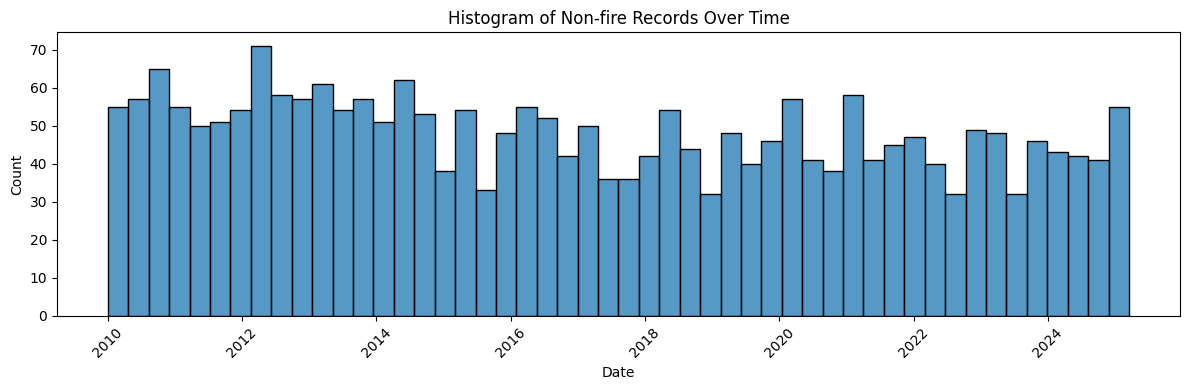

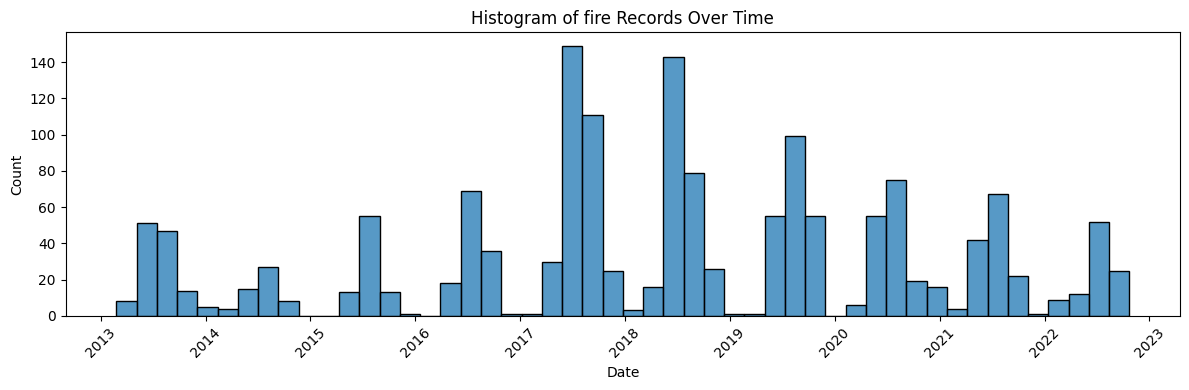

In [49]:
# Check if fire, non-fire data is distributed evenly
df_non_fire = df[df.is_fire == 0]
df_fire = df[df.is_fire == 1]

plt.figure(figsize=(12, 4))
sns.histplot(data=df_non_fire, x='date', bins=50, kde=False)
plt.title("Histogram of Non-fire Records Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
sns.histplot(data=df_fire, x='date', bins=50, kde=False)
plt.title("Histogram of fire Records Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


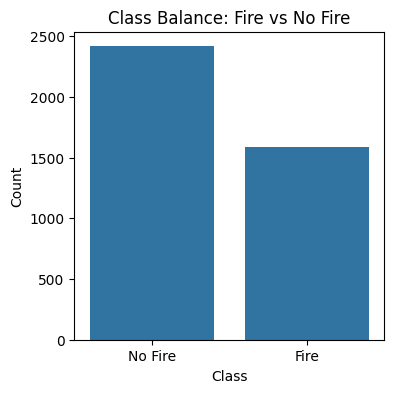

In [50]:
# Plot class balance
plt.figure(figsize=(4,4))
sns.countplot(x=df['is_fire'].map({0: 'No Fire', 1: 'Fire'}))
plt.title("Class Balance: Fire vs No Fire")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


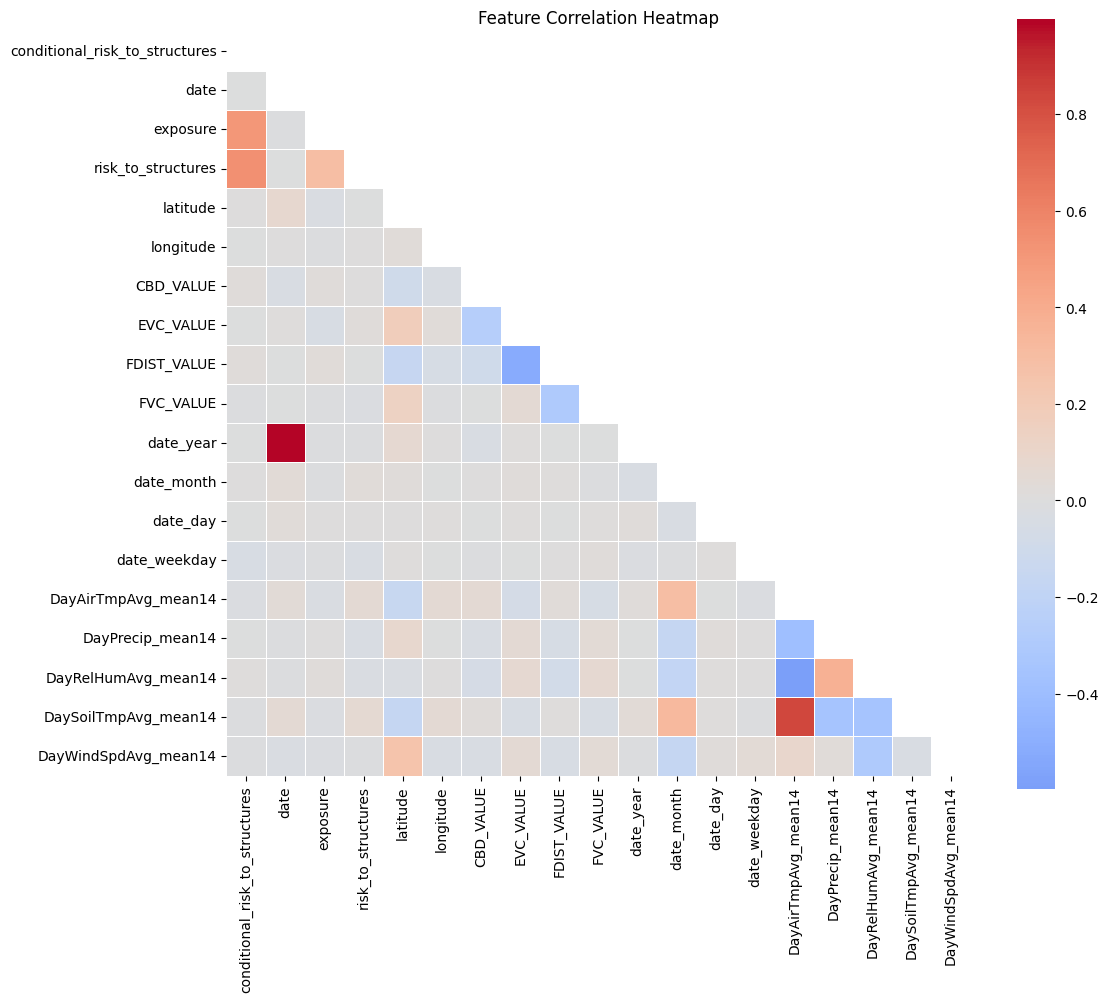

In [51]:
# Correlation heatmap for numerical features
# Just use mean climate data for correlation heatmap
df2 = df.copy()
climate_vars = ['DayAirTmpAvg', 'DayPrecip', 'DayRelHumAvg', 'DaySoilTmpAvg', 'DayWindSpdAvg']
for var in climate_vars:
    cols = [c for c in df.columns if c.startswith(var) if '_mean' not in c]
    df2.drop(columns=cols, inplace=True)

plt.figure(figsize=(12,10))
corr = df2.drop(columns=['is_fire']).corr()  # exclude the label for feature-feature correlation
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


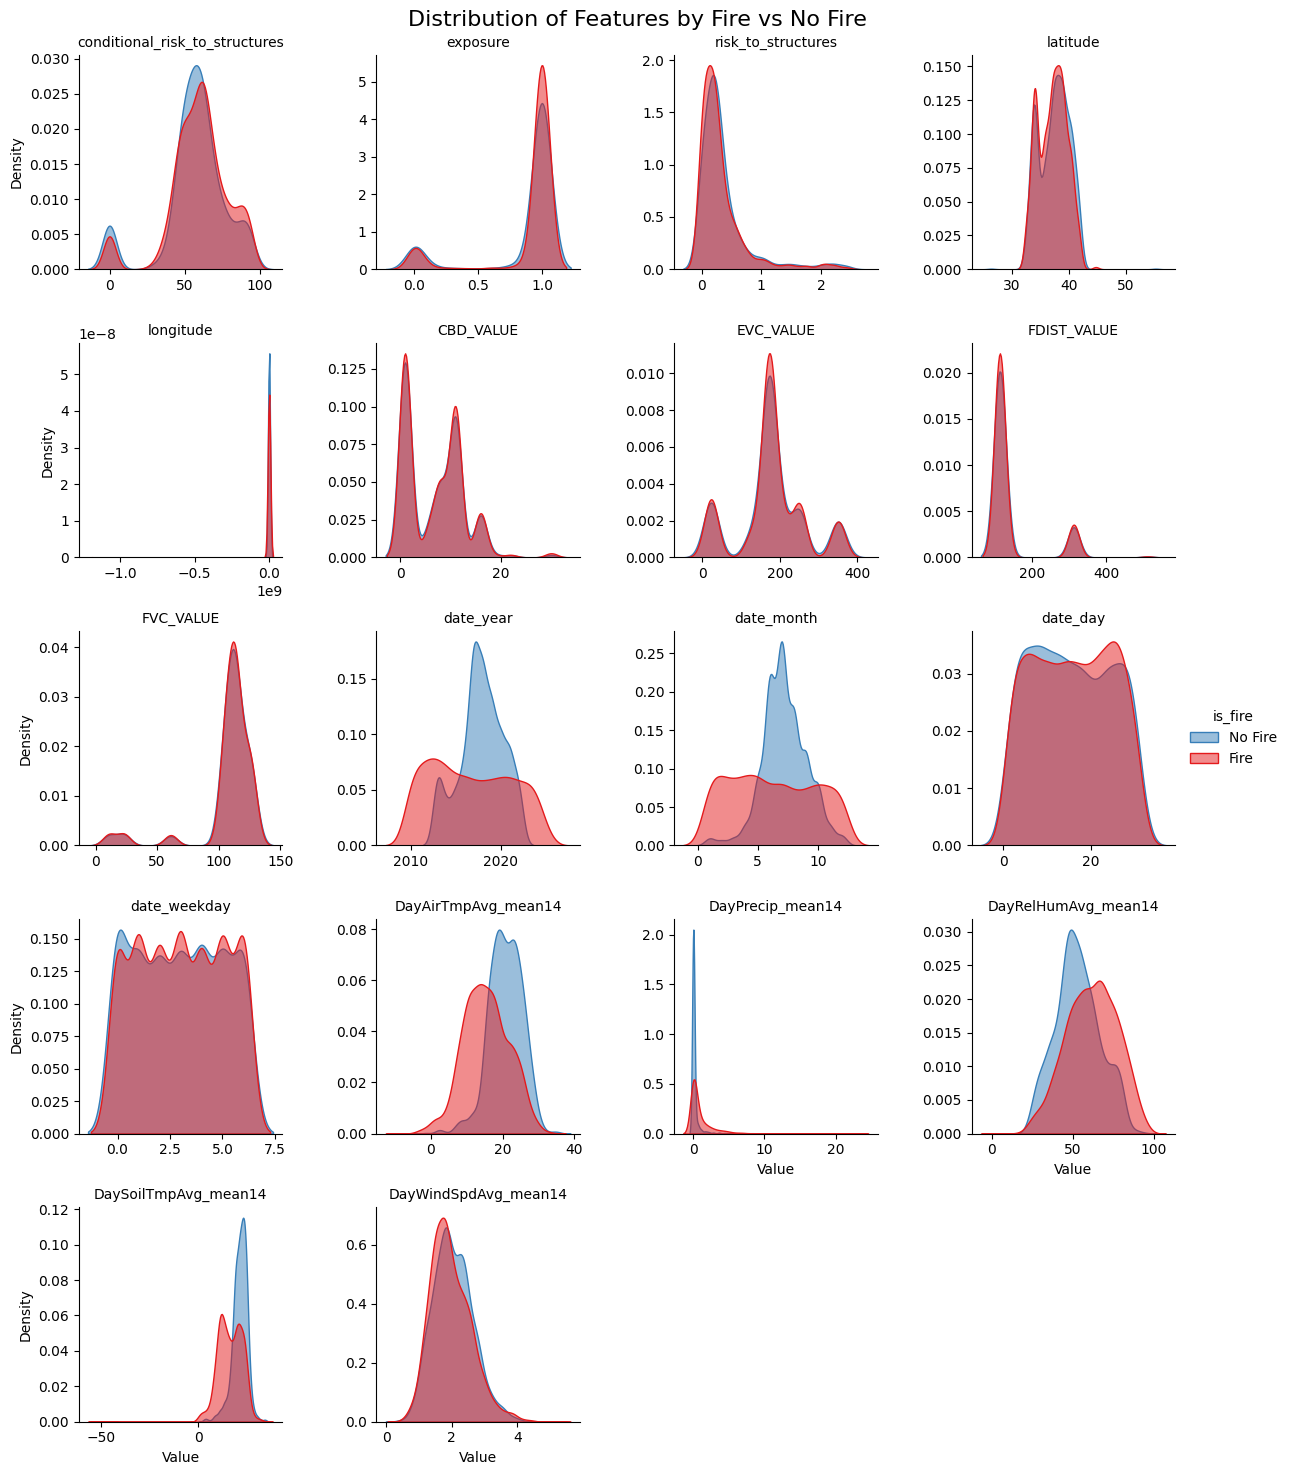

In [52]:
# Total Class-wise Feature Distribution

num_cols = df2.select_dtypes(include=['float64', 'int64']).columns.drop('is_fire')
df_melted = df2.melt(id_vars='is_fire', value_vars=num_cols, var_name='Feature', value_name='Value')

g = sns.FacetGrid(df_melted, col='Feature', col_wrap=4, sharex=False, sharey=False, height=3)
g.map_dataframe(sns.kdeplot, x='Value', hue='is_fire', common_norm=False, fill=True, alpha=0.5, palette='Set1')

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Density")
g.add_legend(title='is_fire', labels=["No Fire", "Fire"])
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Distribution of Features by Fire vs No Fire", fontsize=16)
plt.show()

# Model Training

This is just spliting, scaling dataframe for training models.

For data preprocessing, there can be more functions applied here like normalizing, filling nans, etc.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# One-hot encode categorical features (month and fuel category codes)
df_model = pd.get_dummies(df, columns=['date_month', 'CBD_VALUE', 'EVC_VALUE', 'FDIST_VALUE', 'FVC_VALUE'], drop_first=True)
df_model = df_model.drop(['date'], axis=1)
# Separate features and target
X = df_model.drop('is_fire', axis=1)
y = df_model['is_fire']

# Train-test split (80% train, 20% test), stratified by the target class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling for continuous features (particularly for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set size:", X_train.shape[0], "samples")
print("Test set size:", X_test.shape[0], "samples")
print("Number of features after encoding:", X_train.shape[1])


Training set size: 3200 samples
Test set size: 800 samples
Number of features after encoding: 148


## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Train Logistic Regression
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_log = logreg.predict(X_test_scaled)

# Calculate evaluation metrics
prec_log = precision_score(y_test, y_pred_log)
rec_log  = recall_score(y_test, y_pred_log)
f1_log   = f1_score(y_test, y_pred_log)
acc_log  = accuracy_score(y_test, y_pred_log)
cm_log   = confusion_matrix(y_test, y_pred_log)

print(f"Logistic Regression Metrics:\n"
      f"Precision = {prec_log:.3f}, Recall = {rec_log:.3f}, F1-score = {f1_log:.3f}, Accuracy = {acc_log:.3f}")
print("Confusion Matrix (TN, FP, FN, TP):", cm_log.ravel())


Logistic Regression Metrics:
Precision = 0.595, Recall = 0.584, F1-score = 0.589, Accuracy = 0.677
Confusion Matrix (TN, FP, FN, TP): [357 126 132 185]


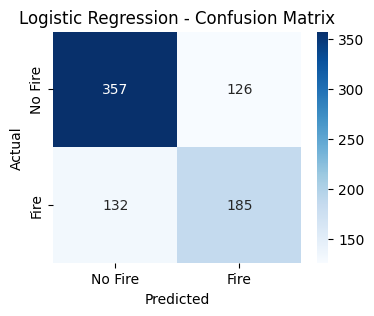

In [33]:
# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(4,3))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire','Fire'], yticklabels=['No Fire','Fire'])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt_model.predict(X_test)

# Evaluation metrics
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt  = recall_score(y_test, y_pred_dt)
f1_dt   = f1_score(y_test, y_pred_dt)
acc_dt  = accuracy_score(y_test, y_pred_dt)
cm_dt   = confusion_matrix(y_test, y_pred_dt)

print(f"Decision Tree Metrics:\n"
      f"Precision = {prec_dt:.3f}, Recall = {rec_dt:.3f}, F1-score = {f1_dt:.3f}, Accuracy = {acc_dt:.3f}")
print("Confusion Matrix (TN, FP, FN, TP):", cm_dt.ravel())


Decision Tree Metrics:
Precision = 0.669, Recall = 0.842, F1-score = 0.746, Accuracy = 0.772
Confusion Matrix (TN, FP, FN, TP): [351 132  50 267]


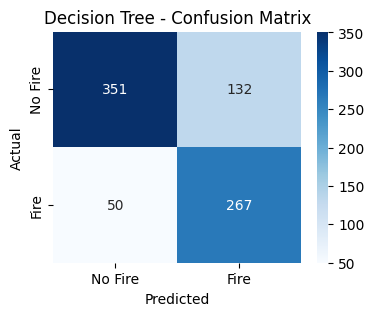

In [35]:
# Confusion matrix heatmap for Decision Tree
plt.figure(figsize=(4,3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire','Fire'], yticklabels=['No Fire','Fire'])
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Gradient Boosting

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb_model.predict(X_test)

# Evaluation metrics
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb  = recall_score(y_test, y_pred_gb)
f1_gb   = f1_score(y_test, y_pred_gb)
acc_gb  = accuracy_score(y_test, y_pred_gb)
cm_gb   = confusion_matrix(y_test, y_pred_gb)

print(f"Gradient Boosting Metrics:\n"
      f"Precision = {prec_gb:.3f}, Recall = {rec_gb:.3f}, F1-score = {f1_gb:.3f}, Accuracy = {acc_gb:.3f}")
print("Confusion Matrix (TN, FP, FN, TP):", cm_gb.ravel())


Gradient Boosting Metrics:
Precision = 0.721, Recall = 0.817, F1-score = 0.766, Accuracy = 0.802
Confusion Matrix (TN, FP, FN, TP): [383 100  58 259]


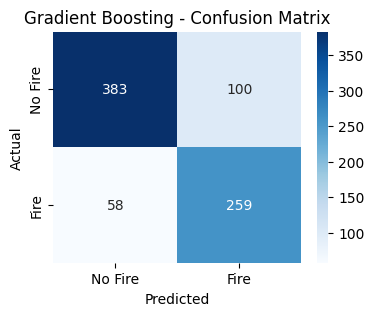

In [37]:
# Confusion matrix heatmap for Gradient Boosting
plt.figure(figsize=(4,3))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire','Fire'], yticklabels=['No Fire','Fire'])
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## XGBoost

In [38]:
from xgboost import XGBClassifier

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation metrics
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb  = recall_score(y_test, y_pred_xgb)
f1_xgb   = f1_score(y_test, y_pred_xgb)
acc_xgb  = accuracy_score(y_test, y_pred_xgb)
cm_xgb   = confusion_matrix(y_test, y_pred_xgb)

print(f"XGBoost Metrics:\n"
      f"Precision = {prec_xgb:.3f}, Recall = {rec_xgb:.3f}, F1-score = {f1_xgb:.3f}, Accuracy = {acc_xgb:.3f}")
print("Confusion Matrix (TN, FP, FN, TP):", cm_xgb.ravel())


/Users/shawn/Library/Caches/pypoetry/virtualenvs/california-wild-fire-prediction-damR8_E7-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Metrics:
Precision = 0.760, Recall = 0.798, F1-score = 0.778, Accuracy = 0.820
Confusion Matrix (TN, FP, FN, TP): [403  80  64 253]


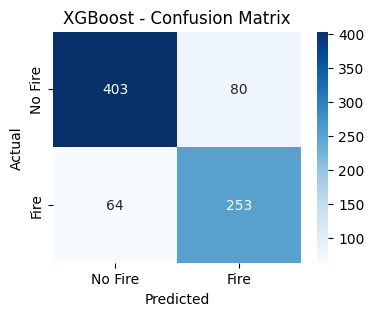

In [39]:
# Confusion matrix heatmap for XGBoost
plt.figure(figsize=(4,3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire','Fire'], yticklabels=['No Fire','Fire'])
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model Comparison

In [40]:
# Summarize metrics for all models
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'XGBoost'],
    'Precision': [prec_log, prec_dt, prec_gb, prec_xgb],
    'Recall':    [rec_log, rec_dt, rec_gb, rec_xgb],
    'F1-score':  [f1_log, f1_dt, f1_gb, f1_xgb],
    'Accuracy':  [acc_log, acc_dt, acc_gb, acc_xgb]
})
results_df.set_index('Model', inplace=True)
results_df


,Precision,Recall,F1-score,Accuracy
Model,,,,
Logistic Regression,0.594855,0.583596,0.589172,0.6775
Decision Tree,0.669173,0.842271,0.745810,0.7725
Gradient Boosting,0.721448,0.817035,0.766272,0.8025
XGBoost,0.759760,0.798107,0.778462,0.8200


# Feature Importance

This is very important part to analyze the model. You should always do this feature importance, and make sure that there is no critical feature on making the model.

Also by doing this, you can check whether there is an error on some columns

Best model based on Recall is: Decision Tree


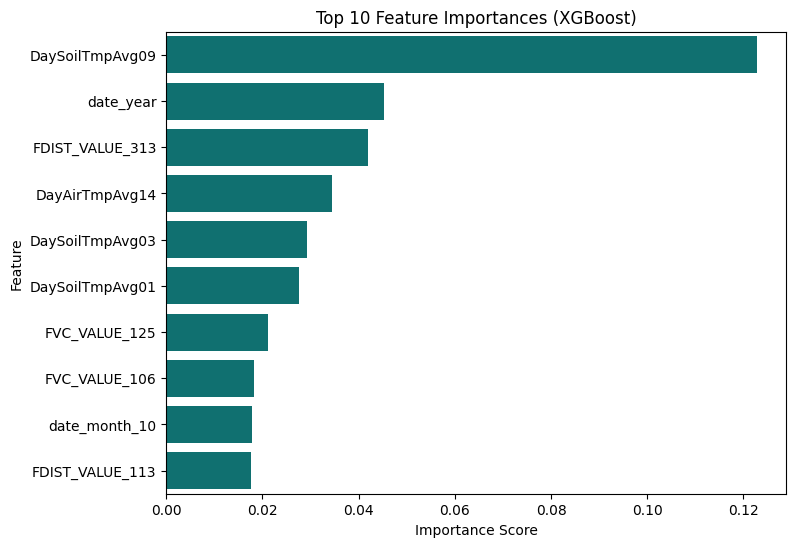

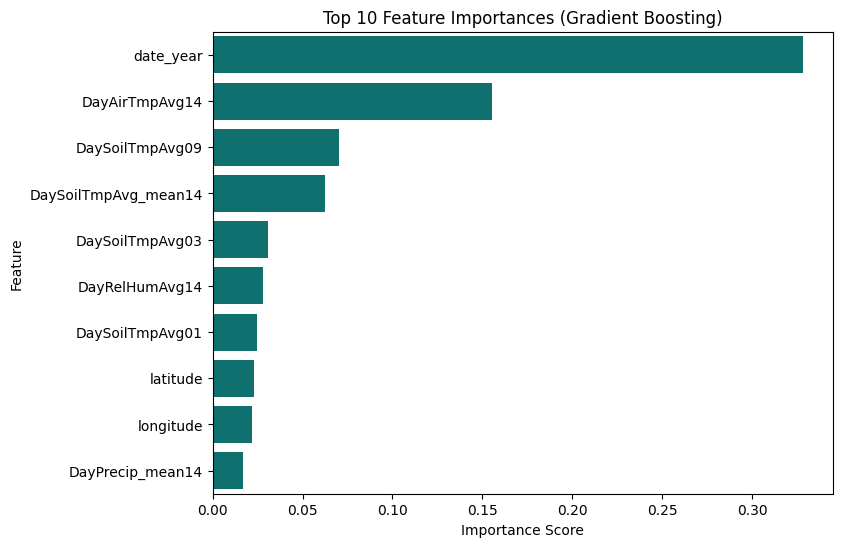

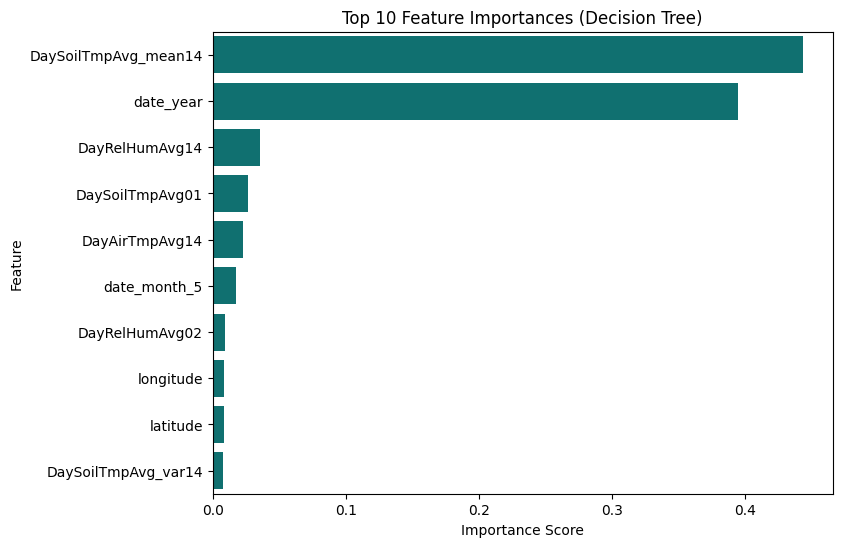

/var/folders/ns/shg9ht0545sbbr41sk4q_zgr0000gn/T/ipykernel_60119/3618659917.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(top_coefs), y=top_features, orient='h', palette=colors)


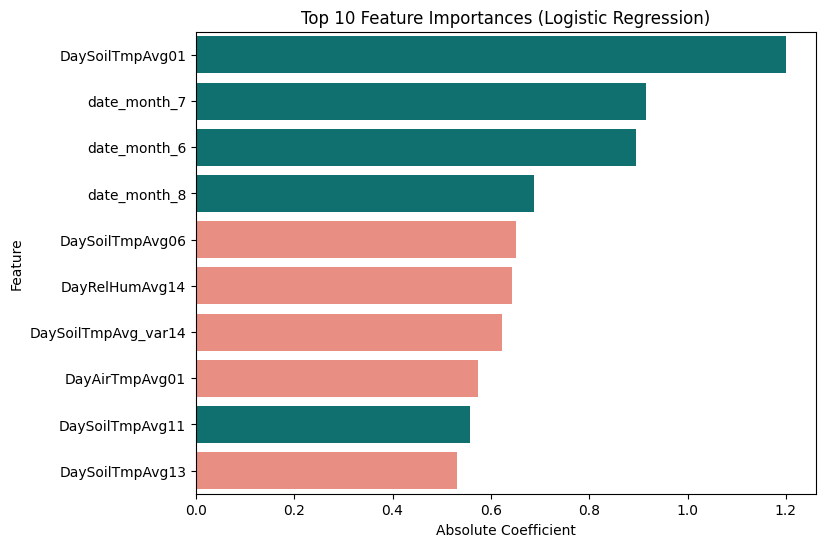

In [41]:
best_model_name = results_df['Recall'].idxmax()
print("Best model based on Recall is:", best_model_name)

model_dict = {
    'XGBoost': xgb_model,
    'Gradient Boosting': gb_model,
    'Decision Tree': dt_model,
    'Log Regression': logreg
}

# If best model is tree-based, get feature importances; if logistic, use coefficients
for model_name, model in model_dict.items():
    if model_name == 'Log Regression':
        coefs = model.coef_[0]
        feature_names = X_train.columns
        top_indices = np.argsort(np.abs(coefs))[::-1][:10]
        top_features = feature_names[top_indices]
        top_coefs = coefs[top_indices]
        plt.figure(figsize=(8,6))
        colors = ['teal' if c > 0 else 'salmon' for c in top_coefs]
        sns.barplot(x=np.abs(top_coefs), y=top_features, orient='h', palette=colors)
        plt.title("Top 10 Feature Importances (Logistic Regression)")
        plt.xlabel("Absolute Coefficient")
        plt.ylabel("Feature")
        plt.show()
    else:
        importances = model.feature_importances_
        feature_names = X_train.columns  # feature names after encoding
        # Get top 10 important features
        top_indices = importances.argsort()[::-1][:10]
        top_features = feature_names[top_indices]
        top_importances = importances[top_indices]
        plt.figure(figsize=(8,6))
        sns.barplot(x=top_importances, y=top_features, orient='h', color='teal')
        plt.title(f"Top 10 Feature Importances ({model_name})")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.show()



# Future Work

1. Feature Engineering (@Rodrigo)
    - Try feature engineering using quantile (Q1, Q3 values) or differential (day2 - day1 value, etc.)
    - Apply various feature engineering and find model best performance.

2. ~~Make scripts that automatically trains model~~ DONE

3. Make ROC-AUC evaluation method and add it on `src/train_model` class. (@Anthony)